# Figure 6, Panel G – Simulate E8.5 IFT Mef2c KD and compare to DEGs

In [6]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from scipy.io import mmread
from scipy.sparse import csr_matrix

In [7]:
bedtools_gcc_path = '/project/clark-saucerman/bedtools2/bin:/apps/software/standard/core/gcc/12.2.0/bin'
original_path = os.environ.get('PATH')
os.environ['PATH'] = bedtools_gcc_path + ':' + original_path
lib_path = '/apps/software/standard/core/gcc/12.2.0/lib64'  # Adjust the path if necessary
os.environ['LD_LIBRARY_PATH'] = lib_path + ':' + os.environ.get('LD_LIBRARY_PATH', '')

In [8]:
import warnings
warnings.filterwarnings('ignore')
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

'0.14.0'

In [9]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

#### Load links and remove Mef2c connections from KO

In [11]:
def remove_and_filter(links_df, genes_to_remove, num_edges):
    for g in genes_to_remove:
        links_df = links_df.drop(links_df[links_df.source=='Mef2c'].index)
        links_df = links_df.drop(links_df[links_df.target=='Mef2c'].index)
        
    return links_df.sort_values('coef_abs', ascending=False).iloc[:num_edges]

In [31]:
thresh_num = 4000

# With pruning
links_wt_e85 = co.load_hdf5(file_path="./data/celloracle/e85/WT_cardiac-subset-links.celloracle.links")
links_ko_e85 = co.load_hdf5(file_path="./data/celloracle/e85/KO_cardiac-subset-links.celloracle.links")

# Without pruning
# links_wt_e85 = co.load_hdf5(file_path="./data/celloracle/e85/WT-no-pruning_cardiac-subset-links.celloracle.links")
# links_ko_e85 = co.load_hdf5(file_path="./data/celloracle/e85/KO-no-pruning_cardiac-subset-links.celloracle.links")

links_wt_e85.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num)
links_ko_e85.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num+1000)

links_ko_e85.filtered_links['IFT-CMs_KO'] = remove_and_filter(links_ko_e85.filtered_links['IFT-CMs_KO'], ['Mef2c'], thresh_num)

In [13]:
def return_adata_raw(timepoint):
    adata = sc.read_h5ad(f'data/adata_objects/{timepoint}_subset.h5ad')
    
    if timepoint == 'e85':
        names = ['pSHF_WT','pSHF_KO', 'aSHF_WT', 'aSHF_KO', 'IFT-CMs_WT', 'IFT-CMs_KO', 'V-CMs_WT', 
                 'V-CMs_KO', 'OFT-CMs_WT', 'OFT-CMs_KO', 'PhM_WT', 'PhM_KO', 'LPM_WT', 'LPM_KO', 
                 'PostM_WT', 'PostM_KO', 'MixM_WT', 'MixM_KO', 'C16_WT', 'C16_KO']
    elif timepoint == 'e9':
        names = ['SHF_WT', 'SHF_KO', 'Pe_WT', 'Pe_KO', 'VP_WT', 'VP_KO', 'CMs-A_WT', 'CMs-A_KO', 
                        'CMs-AVC_WT', 'CMs-AVC_KO', 'CMs-V_WT', 'CMs-V_KO', 'CMs-OFT_WT', 'CMs-OFT_KO', 
                        'PhM_WT', 'PhM_KO', 'C11_WT', 'C11_KO']        
    else:
        return
    
    mapping_dict = dict(zip(range(0, len(names)), names))
    adata.obs['celltype_x_genotype'] = adata.obs['cell_type_pool_x_genotype'].map(mapping_dict)    
    
    if timepoint == 'e9':
        adata.obs.loc[adata.obs['celltype_x_genotype'] == 'CMs-AVC_WT', 'celltype_x_genotype'] = 'CMs-A_WT'
    
    raw_mtx = mmread(f"./data/adata_objects/{timepoint}_matrix.mtx")
    raw_cells = pd.read_csv(f"./data/adata_objects/{timepoint}_raw_cells.csv", header=None)
    raw_genes = pd.read_csv(f"./data/adata_objects/{timepoint}_raw_genes.csv", header=None)
    x = pd.DataFrame(raw_mtx.toarray())
    x.index = raw_genes.values.T[0]
    
    x = x.T
    x.index = raw_cells.values.flatten()
    raw_cells.index = raw_cells.values.flatten()
    raw_genes.index = raw_genes.values.flatten()
    
    new_adata_raw = sc.AnnData(
        X=x.values,  # Use the normalized and log-transformed data
        var=raw_genes,  # Use the same genes
        obs=raw_cells   # Use the same cells
        )
    
    sc.pp.normalize_total(new_adata_raw, target_sum=1e4)
    sc.pp.log1p(new_adata_raw)
    adata.raw = new_adata_raw
    return adata

#### Set timepoint and load adata with raw readouts (req'd for DEG)

In [16]:
timepoint = 'e9'
adata = return_adata_raw(timepoint)

#### Calculate DEG and save results to `de_results`

In [20]:
# Chamber is Atrial because assuming adata_E9 is your AnnData object
chamber = 'A'

# Filter the data to include only the relevant groups
if timepoint == 'e85':
    adata_subset = adata[adata.obs['celltype_x_genotype'].isin([f'{chamber}-CMs_KO', f'{chamber}-CMs_WT'])]
elif timepoint == 'e9':
    adata_subset = adata[adata.obs['celltype_x_genotype'].isin([f'CMs-{chamber}_KO', f'CMs-{chamber}_WT'])]
else:
    print('oops')
    
# adata_subset.X = adata_subset.X + 8

sc.tl.rank_genes_groups(adata_subset, groupby='celltype_x_genotype', method='wilcoxon')
# sc.tl.rank_genes_groups(adata_subset, groupby='celltype_x_genotype', method='wilcoxon', use_raw=False)

# Extract the results into a DataFrame
# import pandas as pd
if timepoint == 'e85':
    de_results = pd.DataFrame(
        {
            'genes': adata_subset.uns['rank_genes_groups']['names'][f'{chamber}-CMs_KO'],
            'logfoldchanges': adata_subset.uns['rank_genes_groups']['logfoldchanges'][f'{chamber}-CMs_KO'],
            'pvals': adata_subset.uns['rank_genes_groups']['pvals'][f'{chamber}-CMs_KO'],
            'pvals_adj': adata_subset.uns['rank_genes_groups']['pvals_adj'][f'{chamber}-CMs_KO']
        }
    )
elif timepoint == 'e9':
    de_results = pd.DataFrame(
        {
            'genes': adata_subset.uns['rank_genes_groups']['names'][f'CMs-{chamber}_KO'],
            'logfoldchanges': adata_subset.uns['rank_genes_groups']['logfoldchanges'][f'CMs-{chamber}_KO'],
            'pvals': adata_subset.uns['rank_genes_groups']['pvals'][f'CMs-{chamber}_KO'],
            'pvals_adj': adata_subset.uns['rank_genes_groups']['pvals_adj'][f'CMs-{chamber}_KO']
        }
    )
else:
    print('oops2')
    
de_results['genes'] = de_results['genes'].apply(lambda x: x[0] if isinstance(x, tuple) else x)

#### Create `all_genes` variable that includes list of all genes in E8.5 network

In [22]:
source_list = list(links_wt_e85.filtered_links['IFT-CMs_WT'].source.unique())
target_list = list(links_wt_e85.filtered_links['IFT-CMs_WT'].target.unique())
all_genes = source_list + target_list

In [23]:
# Step 1: Remove genes with 'mt-' prefix
# genes_to_keep = np.array([gene for gene in adata_subset.var_names if not gene.startswith('mt-')])
genes_to_keep = np.array([gene for gene in adata_subset.var_names 
                          if not (gene.startswith('mt-') or 'Hba' in gene or 'Hbb' in gene or 'Xis' in gene)])


# Step 2: Subset the AnnData object to keep only these genes
adata_subset = adata_subset[:, genes_to_keep]

# Step 3: Check if 'rank_genes_groups' still contains mitochondrial genes
if 'rank_genes_groups' in adata_subset.uns:
    # Replace 'rank_genes_groups' names by filtering out the 'mt-' genes
    rank_genes_names = adata_subset.uns['rank_genes_groups']['names'].copy()
    
    for group in rank_genes_names.dtype.names:
        # Get the current group of gene names
        gene_list = list(rank_genes_names[group])
        
        # Filter out the 'mt-' genes
        non_mt_genes = [gene for gene in gene_list if not (gene.startswith('mt-') or 'Hba' in gene or 'Hbb' in gene or 'Xis' in gene)]
        
        # Update the structure with the filtered list, ensuring the length remains consistent
        adata_subset.uns['rank_genes_groups']['names'][group] = np.array(non_mt_genes + [''] * (len(gene_list) - len(non_mt_genes)))

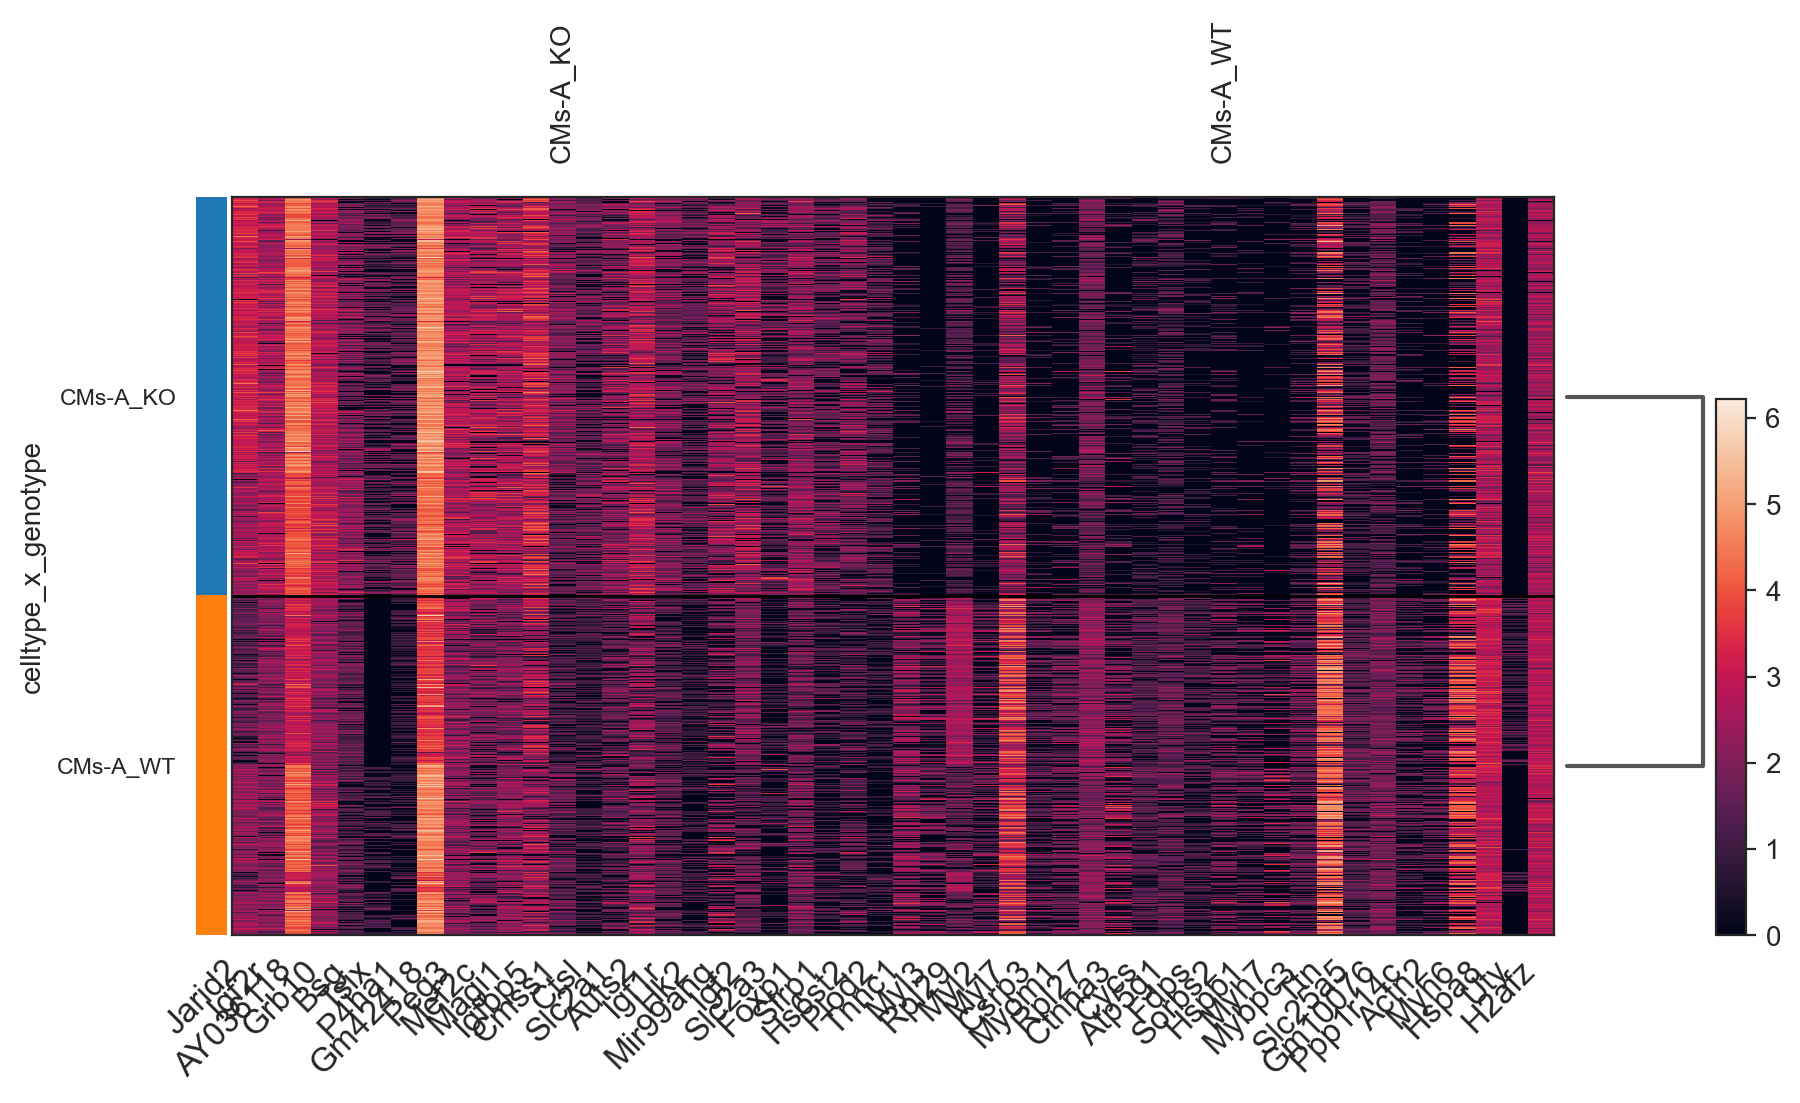

In [24]:
ax = sc.pl.rank_genes_groups_heatmap(
    adata_subset,
    key='rank_genes_groups', 
    n_genes=25,
    figsize=(10, 5),
    show=False  # prevent showing the plot immediately to allow further customization
    )
ax = ax['heatmap_ax']

# Rotate the gene labels and adjust the font size
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)  # Adjust rotation and font size

# Display the heatmap
# plt.tight_layout()
plt.show()

#### Function to get coefficient matrix for perturbation study

In [26]:
def get_coef_matrix(links_df):
    all_genes = np.unique(list(links_df['source'].values) + list(links_df['target'].values))

    all_coefficients = np.zeros((len(all_genes), len(all_genes)))
    coefficients_matrix = pd.DataFrame(all_coefficients, index=all_genes, columns=all_genes)

    for row in links_df.itertuples():
        coefficients_matrix.at[row.source, row.target] = row.coef_mean
    return coefficients_matrix

#### Function to calculate gene change after TF perturbation

In [27]:
def get_gene_change(genes_to_change, coef_matrix, iterations):
    delta_x = np.zeros(coef_matrix.shape[0])

    for g in genes_to_change:
        delta_x[coef_matrix.index.get_loc(g)] = -1

    change = np.zeros(coef_matrix.shape[0])

    for i in range(0, iterations):
        change = change + np.matmul(delta_x, coef_matrix.values)
        delta_x = delta_x + change


    change_dict = dict(zip([x for x in coef_matrix.index], [x for x in change]))

    change_df = pd.DataFrame({'name': [x for x in coef_matrix.index],
                             'delta_x': [x for x in change]})


    pos_genes = []
    neg_genes = []

    for g, val in change_dict.items():
        if val > 0:
            pos_genes.append(g)
        if val < 0: 
            neg_genes.append(g)

    return change_dict, pos_genes, neg_genes, change_df

#### Compare DEG to network simulation of TF knockdown

In [30]:
tf = 'Mef2c'

coef_matrix = get_coef_matrix(links_wt_e85.filtered_links['IFT-CMs_WT'])
gene_change, up_genes, down_genes, change_df = get_gene_change([tf], coef_matrix, iterations=1)
de_lost_in_ko = de_results[de_results.logfoldchanges < -1.5]
de_gained_in_ko = de_results[de_results.logfoldchanges >1.5]

i = 0
print('(POSITIVE RESULT) Genes our model predicts will decrease in KO and are actually downregulated in KO.')

for g in change_df[change_df['delta_x'] < -0.01].sort_values('delta_x')['name'].values:
    if g in de_lost_in_ko['genes'].values:
        print(g)
        i += 1
tp = i
print(i)
print('\n')

print('(POSITIVE RESULT) Genes our model predicts will increase in KO and actually increase in KO')
i = 0
for g in change_df[change_df['delta_x'] > 0.01].sort_values('delta_x')['name'].values:
    if g in de_gained_in_ko['genes'].values:
        print(g)
        i += 1
tn = i
print(i)
print('\n')

print('(NEGATIVE RESULT) Genes our model predicts will decrease in KO, BUT actually INCREASE in KO.')
i = 0
for g in change_df[change_df['delta_x'] < -0.01].sort_values('delta_x')['name'].values:
    if g in de_gained_in_ko['genes'].values:
        print(g)
        i += 1
fp = i
print(i)

print('\n')
print('(NEGATIVE RESULT) Genes our model predicts will increase in KO, BUT actually DECREASE in KO.')
i = 0
for g in change_df[change_df['delta_x'] > 0.01].sort_values('delta_x')['name'].values:
    if g in de_lost_in_ko['genes'].values:
        print(g)
        i += 1
fn = i
print(i)


print(f"{tf}: Accuracy of: {(tp + tn) / (tp+tn+fp+fn)}, and num tf + tn = {tp+tn}")

(POSITIVE RESULT) Genes our model predicts will decrease in KO and are actually downregulated in KO.
Ttn
Ppp1r14c
Tnnc1
Filip1
Myom1
Hdac9
Ctnna3
Fam49a
Csrp3
Mybpc3
Sptb
5430431A17Rik
12


(POSITIVE RESULT) Genes our model predicts will increase in KO and actually increase in KO
Igfbp2
1


(NEGATIVE RESULT) Genes our model predicts will decrease in KO, BUT actually INCREASE in KO.
0


(NEGATIVE RESULT) Genes our model predicts will increase in KO, BUT actually DECREASE in KO.
0
Mef2c: Accuracy of: 1.0, and num tf + tn = 13
